# "Fake news" Clasificacion
# Modelo de redes proyecto


In [3]:
# First we import the required libraries

import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
import io

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K 

import keras
import keras.utils
from keras import utils as np_utils
from tensorflow.python import keras

K.clear_session()

#Version
if float(tf.__version__[0]) < 2.0:
  print('Updating tensorflow')
  !pip install tensorflow==2.0
else:
  print('Correct version of Tensorflow installed.')

Correct version of Tensorflow installed.


Using TensorFlow backend.


In [43]:
# Conectar con el drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# Cargue del data set, se puede cargar o con drive o cargando manualmente el archivo
#df = pd.read_csv('/content/gdrive/My Drive/train.csv')
df = pd.read_csv('train.csv')
df = df.fillna(' ')
df.count()

id        20800
title     20800
author    20800
text      20800
label     20800
dtype: int64

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [10]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
porter_stemmer = PorterStemmer()
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['clean_text'] = df['text'].apply(word_tokenize) # tokenize text.
df['clean_text'] = df['clean_text'].apply(lambda t: [porter_stemmer.stem(w) for w in t]) # steamming text.
df['clean_text'] = df['clean_text'].apply(lambda t: [w for w in t if w not in stop]) # stopwords text.
df['clean_text'] = df['clean_text'].apply(' '.join) # rejoin tokens.

df[['text', 'clean_text']].head()

,text,clean_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,hous dem aid : We ’ even see comey ’ letter ja...
1,Ever get the feeling your life circles the rou...,ever get feel life circl roundabout rather hea...
2,"Why the Truth Might Get You Fired October 29, ...","whi truth might get fire octob 29 , 2016 tensi..."
3,Videos 15 Civilians Killed In Single US Airstr...,video 15 civilian kill In singl US airstrik id...
4,Print \nAn Iranian woman has been sentenced to...,print An iranian woman ha sentenc six year pri...
...,...,...
20795,Rapper T. I. unloaded on black celebrities who...,rapper T. I. unload black celebr met donald tr...
20796,When the Green Bay Packers lost to the Washing...,green bay packer lost washington redskin week ...
20797,The Macy’s of today grew from the union of sev...,maci ’ today grew union sever great name ameri...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...","nato , russia To hold parallel exercis In balk..."


In [27]:
# Tokenizacion 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
print(vocab_size)

sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

157614


Luego de la eliminación de stopwords, se evidenció un cambio importante en la disminución del vocabulario pasando de 238051 a 237991 del tamaño del vocabulario

In [28]:
padded.shape

(20800, 500)

In [29]:
#particion del dataset en entrenamiento y test
split = 0.2
split_n = int(round(len(padded)*(1-split),0))

train_data = padded[:split_n]
train_labels = df['label'].values[:split_n]
test_data = padded[split_n:]
test_labels = df['label'].values[split_n:]

In [30]:
# Representacion de palabras
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
print(len(coefs))
#matriz de palabras embebidas
embeddings_matrix = np.zeros((vocab_size+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-22 01:50:56--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  93.4MB/s    in 3.5s    

2020-06-22 01:51:00 (93.4 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]

100


In [31]:
# En este punto se construye la arquitectura del modelo (las capas que este tendrá)    
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 100, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dropout(0.2),  
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),  
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
#Compilacion
#Funcion de perdida entropia cruzada binaria
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
#Entrenamiento
history = model.fit(train_data, train_labels, epochs=5, batch_size=100, validation_data=[test_data, test_labels])
print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         15761500  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

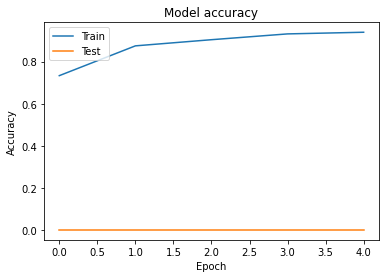

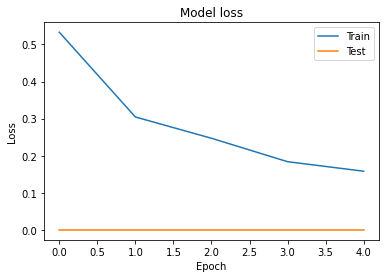

In [33]:
# Visualize the results:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [37]:
# Guardar el Modelo
model.save('ConvolutionalModel.h5')

In [29]:
#cargue del modelo almacenado
new_model = keras.models.load_model('ConvolutionalModel.h5')

In [30]:
new_model

In [61]:
import keras
import tensorflow as tf 
from keras.models import load_model
from tensorflow.keras.models import load_model

model = load_model('ConvolutionalModel.h5')
model.summary()

# load dataset
# dataset = loadtxt("train.csv", delimiter=",")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         23805200  
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 20)          6800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0

In [55]:
score = model.evaluate(test_data, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 94.59%


In [53]:
model.predict(test_data, workers=4)

array([[0.99832076],
       [0.97851276],
       [0.99921495],
       ...,
       [0.08065808],
       [0.99934524],
       [0.9991416 ]], dtype=float32)

In [ ]:
#prueba parametro API
df = pd.read_csv('train.csv')
df = df.fillna(' ')
df.count()